In [0]:
#@title Setup
#@markdown Run this cell! The first time you run this, follow the link that appears to connect to google drive.

!pip install pulp

from collections import defaultdict
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import *
import seaborn as sns
sns.set()

from google.colab import drive
drive.mount('gdrive')

# Define functions
def search_memo(f):
  """Tailored memoization for seach function"""
  cache = dict()
  def wrapper(adj_list, u=None, d=0):
    if (u, d) not in cache:
      cache[(u, d)] = tuple(f(adj_list, u, d))
    return cache[(u, d)]
  return wrapper

@search_memo
def search(adj_list, u=None, d=0):
  """
  Performs a DFS on a graph for all (path, distance) pairs.
  Optional params:
  - u : Starting vertice. If u is not supplied, DFS searches for all possible u.
  - d : Starting distance (Default: 0)
  """

  if u is None:
    for v in adj_list:
      for result in search(adj_list, v, d):
        yield result

  elif u in adj_list:
    for v in adj_list[u]:
      for path, path_dist in search(adj_list, v, d + adj_list[u][v]):
        yield ((u, *path), path_dist)

  elif u not in adj_list:
    yield ((u,), d)

def cross(A, B, f=lambda a,b: a+b):
  """Returns a matrix of all combination of items in A and B conbined by f"""
  return np.array([[f(a,b) for b in B] for a in A])

def solveLPs(layover_cost_per_hour, min_linkage, min_crew, max_crew, max_flights, verbose=True):
  """Solves both LPs with supplied parameters and returns the LP objects"""  
  ###################
  # Linkage Problem #
  ###################

  tic1 = time.time()
  
  # Set variables for linkage problem
  F = flights.index.values

  linkage = LpProblem("linkage", LpMinimize)
  link = LpVariable.dicts("link", (F, F), 0, 1, LpInteger)

  # Objective
  linkage += lpSum([layover[i, j] * link[i][j] for i in F for j in F]), "objective"

  # Constraints
  for index, i in enumerate(F):
    linkage += lpSum([link[i][j] for j in F]) >= min_linkage, f"arrival_{index}" # outgoing flights should be assigned at least min_linkage times

  for index, j in enumerate(F):
    linkage += lpSum([link[i][j] for i in F]) >= min_linkage, f"departure_{index}" # incoming flights should be assigned at least min_linkage times

  # Solve!
  print('Linkage LP: ', end='')
  print('Success!' if linkage.solve() == 1 else 'Oof something went wrong ; ;')
  
  toc1 = time.time()
  
  ###################
  # Data processing #
  ###################

  tic2 = time.time()

  # Filter feasible linkages
  edge_list = {(i, j): layover[i, j] for i in F for j in F if value(link[i][j]) != 0}
  feasible = {key:val for key,val in edge_list.items() if val != BIG_M}

  # Convert to adjacency list
  L = defaultdict(dict)
  for a, b in feasible:
    L[a][b] = feasible[(a, b)]
  L = dict(L)

  # DFS for flight routes and total layover times
  routes = dict(search(L))
  routes = {k:v for k,v in routes.items() if len(k) <= max_flights}

  toc2 = time.time()

  ######################
  # Assignment problem #
  ######################

  tic3 = time.time()

  num_crew = len(F) * max_crew # Maximal crew demand

  # Initialize variables and parameters
  crew_cost = pd.read_csv(f'/content/gdrive/My Drive/IE2110_Group_10_Project/data team/Crew_data.csv')
  crew_cost = crew_cost['Addon pay (per hour)']
  crew_cost = crew_cost.sample(num_crew, replace=True)

  # get cost for each assignment 
  # = crew_pay + layover_cost
  # = (hourly_add_on_pay_in_dollars * 8h / flight * num flights in route) + ($100 * layover_time_in_hours)
  c = cross(routes.items(), crew_cost, lambda r, c: 8*c*len(r[0]) + layover_cost_per_hour*r[1])

  # Crew members
  S = list(range(num_crew))

  # Flight schedules
  R = dict(enumerate(routes))

  # Groups of schedules by the flights they contain
  R_indexed = [list() for f in F]
  for i, route in R.items():
    for flight in route:
      R_indexed[flight].append(i)

  # Initialize LP
  assignment = LpProblem("assignment", LpMinimize)
  assign = LpVariable.dicts("assign", (R, S), 0, 1, LpInteger)

  # Objective
  assignment += lpSum([c[r][s] * assign[r][s] for r in R for s in S]), "objective" # min cost of assigning schedules to crew members

  # Constraints
  for i, s in enumerate(S):
    assignment += lpSum([assign[r][s] for r in R]) <= 1, f"assignment_{i}" # each crew is assigned to one schedule

  for i, Ri in enumerate(R_indexed):
    if Ri == []: continue # skip if flight is infeasible from pairing problem
    assignment += lpSum([assign[r][s] for r in Ri for s in S]) <= max_crew, f"max_crew_{i}" # no more than max_crew per flight
    assignment += lpSum([assign[r][s] for r in Ri for s in S]) >= min_crew, f"min_crew_{i}" # no less than min_crew per flight

  # Solve!
  print('Assignment LP: ', end='')
  print('Success' if assignment.solve() == 1 else 'Oof something went wrong ; ;')

  toc3 = time.time()

  # Timing summary
  print()
  print('===== Time elapsed =====')
  print(f'Linkage LP: {toc1-tic1:.3f}s')
  print(f'Data processing: {toc2-tic2:.3f}s')
  print(f'Assignment LP: {toc3-tic3:.3f}s')
  print('========================')
  
  if verbose is True:
    # Print solutions
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(np.log(layover) * cross(F, F, lambda a,b: value(link[a][b]) != 0), cmap='pink')
    ax.set_title(f'layover costs of best {min_linkage} pairing(s) for all flights')
    ax.set_ylabel('Arrivals')
    ax.set_xlabel('Departures')
    plt.show()

    print()
    print('Layover cost for optimal linkages')
    for key, val in feasible.items():
      print(f'{key} -> {val}')

    obj = linkage.objective.value()
    n_infeasible = obj // BIG_M
    obj_feasible = obj % BIG_M
    print(f'total layover time (hours) = {obj_feasible} ({len(feasible)}/{len(edge_list)} feasible pairings)')
    print('number of routes:', len(routes))

    schedule = [(r,s) for r in R for s in S if value(assign[r][s]) != 0]
    schedule.sort(key=lambda x: x[0])

    table = pd.DataFrame(columns=F, index=pd.unique([s for r,s in schedule]))
    for r, s in schedule:
      for flight in R[r]:
        table.loc[s, flight] = 1

    plt.figure(figsize=(10, 15))
    ax = sns.heatmap(table.fillna(0))
    ax.set_title('Crew-Flight assignments for minimal crew')
    ax.set_ylabel('Crew')
    ax.set_xlabel('Flight')
    plt.show()

    print()
    print('Routes assigned to each crew')
    for r, s in schedule:
      print(f'{s} -> {R[r]}')
    
    print()
    print('Number of crew to each route')
    by_route = pd.DataFrame(schedule)
    by_route.columns = ['route', 'crew']
    counts = by_route.groupby('route').count()
    print(counts)

    print()
    obj = assignment.objective.value()
    print(f'total cost of scheduling all flights = {obj}')
    print(f'total employees used = {counts.values.sum()}')
    
  # Return LPs for processing
  return linkage, assignment



     |████████████████████████████████| 13.6MB 169kB/s 
  Created wheel for pulp: filename=PuLP-1.6.10-cp36-none-any.whl size=12269903 sha256=f498aba7ccd91f838143251a1bc9514d42b44e8e46b3a704230afb0c541dbe64
  Stored in directory: /root/.cache/pip/wheels/5e/76/77/e28b22219e46e3b4b033f02e8b36b2770ae545bdcf60c2b224
Successfully built pulp
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


Layover costs loaded into matrix "layover"


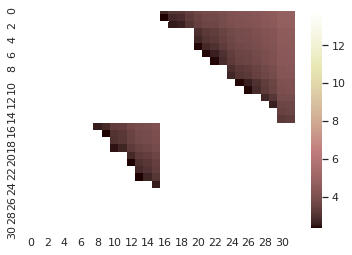

data loaded into dataframe "flights"


,flight,from,to,departure,arrival,duration_hours,min_crew,max_crew
0,1,SG,Melbourne,2019-11-02 10:00:00,2019-11-02 18:00:00,8,6,12
1,2,SG,Melbourne,2019-11-02 16:10:00,2019-11-03 00:10:00,8,6,12
2,3,SG,Melbourne,2019-11-02 20:05:00,2019-11-03 04:05:00,8,6,12
3,4,SG,Melbourne,2019-11-03 07:45:00,2019-11-03 15:45:00,8,6,12
4,5,SG,Melbourne,2019-11-03 11:00:00,2019-11-03 19:00:00,8,6,12


In [0]:
#@title Load data

#@markdown Set path to the `data team` folder
PATH = '/content/gdrive/My Drive/IE2110_Group_10_Project/data team' #@param {type: 'string'}

# Layover cost matrix
layover = np.genfromtxt(f'{PATH}/layover.csv', delimiter=',')

# Flight data
flights = pd.read_csv(f'{PATH}/flights.csv')
time_cols = ['departure', 'arrival']
num_cols = ['duration_hours', 'min_crew', 'max_crew']

flights[time_cols] = flights[time_cols].apply(pd.to_datetime)
flights[num_cols] = flights[num_cols].apply(pd.to_numeric)
flights.index = range(32)

# Check data
print('Layover costs loaded into matrix "layover"')
sns.heatmap(np.log(layover), cmap='pink')
plt.show()

print('data loaded into dataframe "flights"')
flights.head()

Linkage LP: Success!
Assignment LP: Success

===== Time elapsed =====
Linkage LP: 0.091s
Data processing: 0.001s
Assignment LP: 2.706s


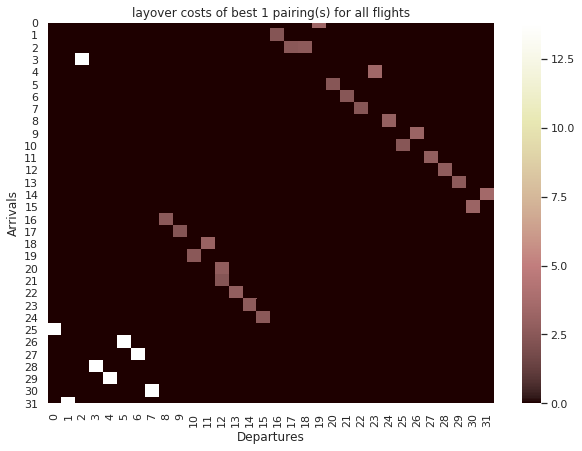


Layover cost for optimal linkages
(0, 19) -> 31.583333333333332
(1, 16) -> 10.416666666666666
(2, 17) -> 12.583333333333334
(2, 18) -> 13.833333333333334
(4, 23) -> 30.583333333333332
(5, 20) -> 10.833333333333334
(6, 21) -> 10.833333333333334
(7, 22) -> 11.0
(8, 24) -> 18.833333333333332
(9, 26) -> 24.416666666666668
(10, 25) -> 10.833333333333334
(11, 27) -> 17.166666666666668
(12, 28) -> 15.583333333333334
(13, 29) -> 13.833333333333334
(14, 31) -> 35.0
(15, 30) -> 24.916666666666668
(16, 8) -> 13.166666666666666
(17, 9) -> 10.333333333333334
(18, 11) -> 22.5
(19, 10) -> 12.25
(20, 12) -> 16.416666666666668
(21, 12) -> 10.333333333333334
(22, 13) -> 16.666666666666668
(23, 14) -> 14.833333333333334
(24, 15) -> 13.166666666666666
total layover time (hours) = 421.9166666669771 (25/33 feasible pairings)
number of routes: 24


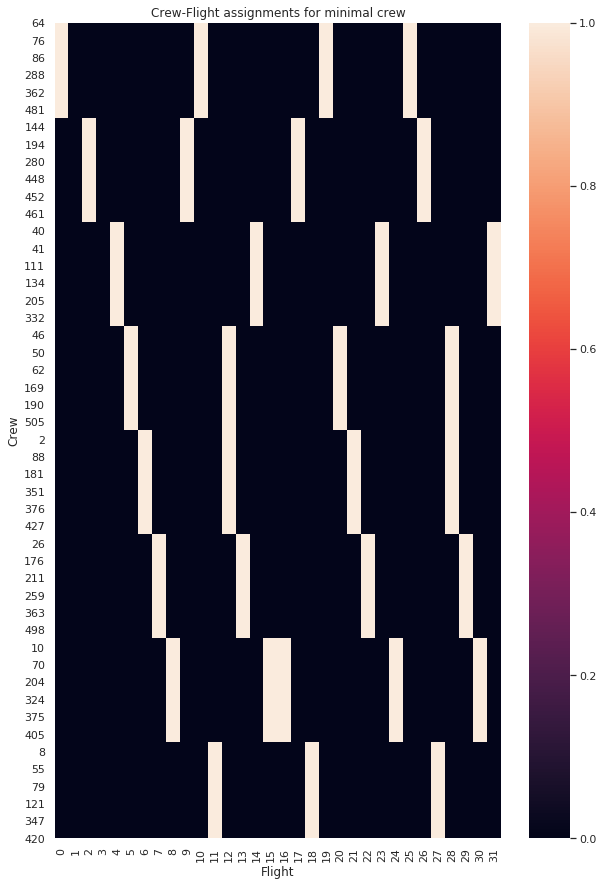


Routes assigned to each crew
64 -> (0, 19, 10, 25)
76 -> (0, 19, 10, 25)
86 -> (0, 19, 10, 25)
288 -> (0, 19, 10, 25)
362 -> (0, 19, 10, 25)
481 -> (0, 19, 10, 25)
144 -> (2, 17, 9, 26)
194 -> (2, 17, 9, 26)
280 -> (2, 17, 9, 26)
448 -> (2, 17, 9, 26)
452 -> (2, 17, 9, 26)
461 -> (2, 17, 9, 26)
40 -> (4, 23, 14, 31)
41 -> (4, 23, 14, 31)
111 -> (4, 23, 14, 31)
134 -> (4, 23, 14, 31)
205 -> (4, 23, 14, 31)
332 -> (4, 23, 14, 31)
46 -> (5, 20, 12, 28)
50 -> (5, 20, 12, 28)
62 -> (5, 20, 12, 28)
169 -> (5, 20, 12, 28)
190 -> (5, 20, 12, 28)
505 -> (5, 20, 12, 28)
2 -> (6, 21, 12, 28)
88 -> (6, 21, 12, 28)
181 -> (6, 21, 12, 28)
351 -> (6, 21, 12, 28)
376 -> (6, 21, 12, 28)
427 -> (6, 21, 12, 28)
26 -> (7, 22, 13, 29)
176 -> (7, 22, 13, 29)
211 -> (7, 22, 13, 29)
259 -> (7, 22, 13, 29)
363 -> (7, 22, 13, 29)
498 -> (7, 22, 13, 29)
10 -> (16, 8, 24, 15, 30)
70 -> (16, 8, 24, 15, 30)
204 -> (16, 8, 24, 15, 30)
324 -> (16, 8, 24, 15, 30)
375 -> (16, 8, 24, 15, 30)
405 -> (16, 8, 24, 15, 30)


In [0]:
#@title Model Parameters
#@markdown This is probably the easiest way to do things! Just change the values and run the cell (ctrl-enter)

# Other parameters
BIG_M = 10e5

LAYOVER_COST_PER_HOUR = 2.5 #@param {type: 'number'}
MIN_LINKAGE = 1 #@param {type: 'integer'}
MIN_CREW = 6 #@param {type: 'integer'}
MAX_CREW = 16 #@param {type: 'integer'}
MAX_FLIGHTS = 5 #@param {type: 'integer'}

linkage, assignment = solveLPs(
    layover_cost_per_hour = LAYOVER_COST_PER_HOUR,
    min_linkage = MIN_LINKAGE,
    min_crew = MIN_CREW,
    max_crew = MAX_CREW,
    max_flights = MAX_FLIGHTS,
)